# Climate Coding Challenge

Climate change is impacting the way people live around the world

# Plot your results

## STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [1]:
%store -r

In [2]:
import matplotlib.pyplot as plt
import holoviews as hv
import hvplot.pandas  # adds .hvplot to DataFrames/Series
hv.extension('bokeh')  # important!
import pandas as pd

In [11]:
## I noticed the some of the data is bad. I read about the flags, and want to use only the acceptable data:
# Keep only '...' flagged data
# Keep only rows where qcflag is exactly '...'
q = co2_df["qcflag"].fillna("").astype(str).str.pad(3, fillchar=".")
co2_df = co2_df[q == "..."].copy()



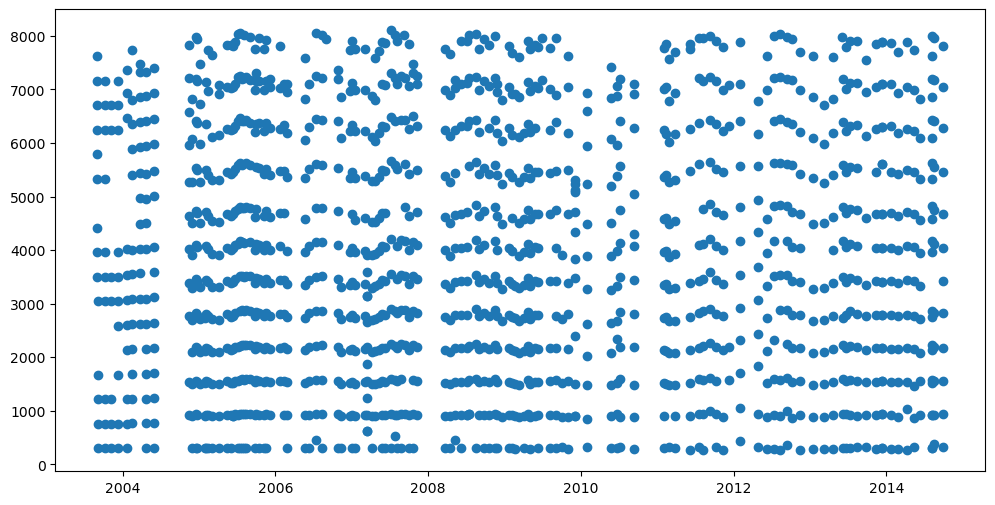

In [12]:

#  Altitude (meters) over time
plt.figure(figsize=(12, 6))
plt.scatter(co2_df["time_decimal"], co2_df["altitude"])
plt.show()

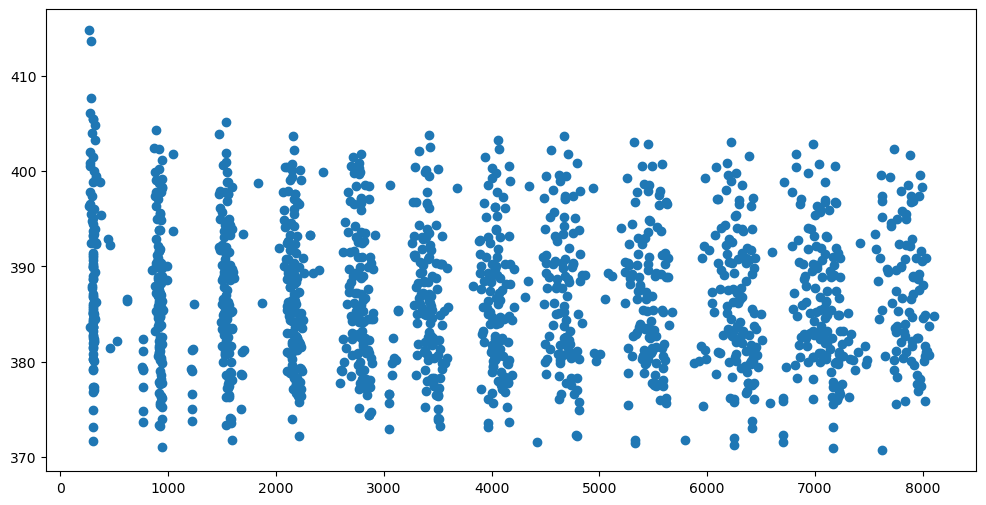

In [13]:
#  Altitude (meters) over time
plt.figure(figsize=(12, 6))
plt.scatter(co2_df["altitude"], co2_df["value"])
plt.show()

In [14]:
co2_df.hvplot.scatter(
    x='altitude', y='value',
    title='CO₂ vs Altitude',
    tools=['pan', 'wheel_zoom', 'box_zoom', 'reset', 'hover'],
    responsive=True, height=450,
    size=5, alpha=0.6
)

:Scatter   [altitude]   (value)

In [15]:
print(co2_df['value'].min(), co2_df['value'].max())


370.7 414.8


In [16]:

co2_df.hvplot.scatter(
    x='time_decimal', y='altitude',
    color='value',                 # <— use 'color' explicitly
    cmap='viridis',
    clim=(287.06, 450),            # lock color scale
    clabel='CO₂ (ppm)',            # colorbar label
    colorbar=True,
    tools=['pan','wheel_zoom','box_zoom','reset','hover'],
    responsive=True, height=500, width=900,
    size=8, alpha=0.7
)


:Scatter   [time_decimal]   (altitude,value)

In [17]:
subset = co2_df[(co2_df["altitude"] >= 7000) & (co2_df["altitude"] <= 9000)]

subset.hvplot.scatter(
    x='time_decimal', y='altitude',
    c='value',
    cmap='viridis',
    clim=(370, 500),         # fixed color scale
    colorbar=True,
    title='Altitude 7000–9000 m (colored by CO₂)',
    tools=['pan', 'wheel_zoom', 'box_zoom', 'reset', 'hover'],
    responsive=True, height=500, width=900,
    size=8, alpha=0.7
)


:Scatter   [time_decimal]   (altitude,value)

In [18]:


# CO₂ vs time
subset.hvplot.scatter(
    x='time_decimal', y='value',
    cmap='viridis',
    clim=(370, 500),
    colorbar=True,
    title='CO₂ vs Time (7000–9000 m)',
    tools=['pan', 'wheel_zoom', 'box_zoom', 'reset', 'hover'],
    responsive=True, height=500, width=900,
    size=8, alpha=0.7
)


:Scatter   [time_decimal]   (value)